# Comparing Explainability Methods Under a White Box Model
This is a "fluorescent test," conducted under laboratory conditions with fluorescent lighting. In this test, we will generate synthetic data with known dynamics for the response variable. Next, we will calculate global explanations using various explainability methods and compare them against the ground truth.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

from xai_compare.explainer_factory import ExplainerFactory
from xai_compare.explainer_utilities import run_and_collect_explanations, permutation_feature_importance
from xai_compare.white_box_model.white_box import WhiteBoxRegressor
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

## Generate a White-Box Model and Data

In [2]:
# model = WhiteBoxRegressor()
# df = model.generate_synthetic_data(n_samples=1000, with_y=True)
# X, y = df.drop(['y'], axis=1), df[['y']]

In [3]:
n_samples = 1000
n_features = 10
feature_columns = [f'f_{i+1}' for i in range(n_features)]

X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_features, noise=0, random_state=42)
X = pd.DataFrame(X, columns=feature_columns)
y = pd.DataFrame(y, columns=['target'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Visualize Features and Target

<Axes: >

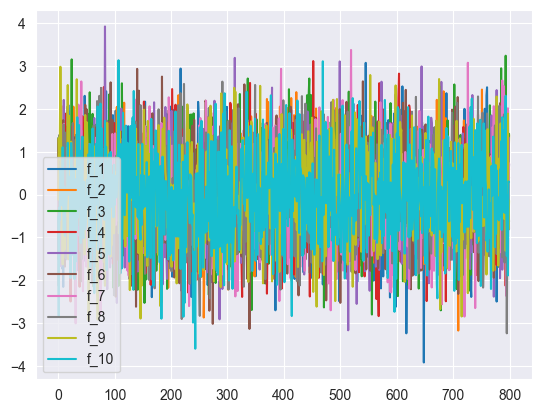

In [6]:
X_train.plot()

<Axes: >

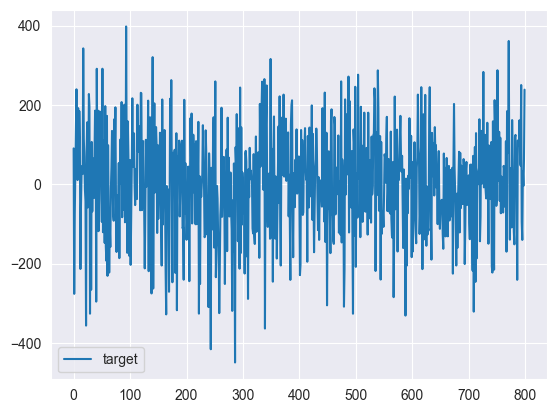

In [7]:
y_train.plot()

## Calculate SHAP and LIME explanation and Compare to Ground Truth

In [8]:
explainer_factory = ExplainerFactory(model, X_train, X_test, y_train, y_test)
results = run_and_collect_explanations(explainer_factory, X_train)
results['ground_truth'] = (X_train * model.coef_).mean()


 SHAP explanation created

 LIME explanation created

 EBM explanation created


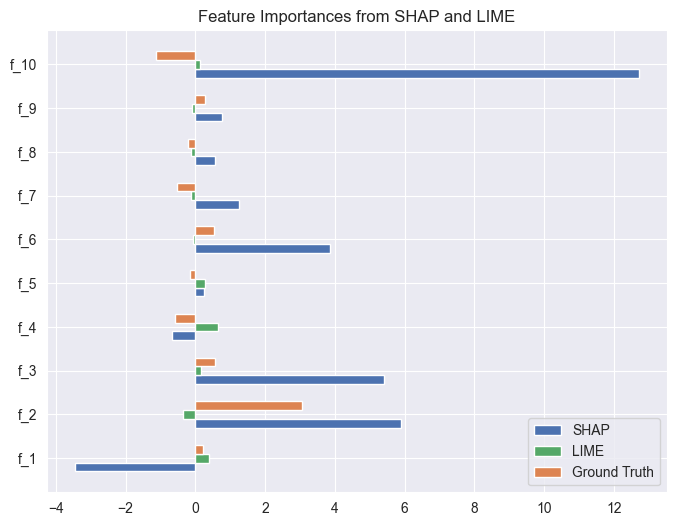

In [9]:
colors = sns.color_palette("deep")
plt.figure(figsize=(8, 6))

bar_positions = np.arange(len(results))  # Positions of the bars
bar_width = 0.2  # Adjust bar width to fit all bars

# Plotting the bars with adjusted positions
plt.barh(bar_positions - bar_width, results['SHAP Value'], height=bar_width, label='SHAP', color=colors[0])  # SHAP values
plt.barh(bar_positions, results['LIME Value'], height=bar_width, label='LIME', color=colors[2])  # LIME values
plt.barh(bar_positions + bar_width, results['ground_truth'], height=bar_width, label='Ground Truth', color=colors[1])  # Ground Truth values

plt.yticks(bar_positions, results.index)  #labels

plt.title('Feature Importances from SHAP and LIME')
plt.legend()
plt.show()

## Calculate permutation feature importance

In [10]:
feature_importances = permutation_feature_importance(model, X_test, y_test, metric='mse', random_state=42)

feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

feature_importances_df

,importance
f_5,-65.394299
f_8,-89.817390
f_4,-216.227266
f_9,-222.834167
f_7,-1635.261074
f_3,-2165.195897
f_1,-2247.641235
f_6,-8050.914235
f_2,-11350.285837
f_10,-12635.377508


In [11]:
import matplotlib.pyplot as plt

def plot_results(df):

    max_importance = df['importance'].max()
    std_importance = df['importance'].std()

    # Apply z-score normalization to the 'importance' column
    df['importance'] = (df['importance'] - max_importance) / std_importance

    fig, ax = plt.subplots(figsize=(12, 6))

    df.plot(kind='bar', ax=ax)
    ax.set_ylabel('Value')
    ax.set_xlabel('Feature')
    ax.set_title('SHAP, LIME, and Importance Values for Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_mse(shap_mse_values, lime_mse_values):
    # Plot the MSE values
    plt.figure(figsize=(10, 6))
    plt.plot(shap_mse_values, label='SHAP MSE')
    plt.plot(lime_mse_values, label='LIME MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title('Stability of SHAP and LIME Values')
    plt.legend()
    plt.grid(True)
    plt.show()

## Evaluate the consistency of SHAP and LIME

In [12]:
from sklearn.metrics import mean_squared_error

def evaluate_explainers(model, X_data, y_data, metric='mse', threshold=0.2, random_state=None):
    # Copy the data to avoid modifying the original
    current_X = X_data.copy()
    current_y = y_data.copy()
    current_model = model

    # Get the list of column names
    columns = X_data.columns.tolist()
    n = len(columns)
    remaining_features = n * threshold

    # Initialize variables to store SHAP and LIME MSE values
    shap_values_prev = None
    lime_values_prev = None
    shap_mse_values = []
    lime_mse_values = []

    # Loop until the number of features is reduced to the desired threshold
    while len(columns) > remaining_features:
        # Get SHAP and LIME values
        explainer_factory = ExplainerFactory(current_model, X_train=current_X, y_train=current_y)
        shap_lime_importance = run_and_collect_explanations(explainer_factory, current_X)
        shap_values = shap_lime_importance['SHAP Value']
        lime_values = shap_lime_importance['LIME Value']

        # Calculate MSE if this is not the first iteration
        if shap_values_prev is not None:
            shap_mse = mean_squared_error(shap_values_prev, shap_values)
            lime_mse = mean_squared_error(lime_values_prev, lime_values)
            shap_mse_values.append(shap_mse)
            lime_mse_values.append(lime_mse)

        # Update previous values for the next iteration
        shap_values_prev = shap_values.copy()
        lime_values_prev = lime_values.copy()

        # Calculate permutation feature importance
        feature_importances_dict = permutation_feature_importance(current_model, current_X, current_y, metric, random_state)
        feature_importances_df = pd.DataFrame.from_dict(feature_importances_dict, orient='index', columns=['importance'])

        # Find the least important feature
        sorted_feature_importances = feature_importances_df.sort_values(by='importance', ascending=True, key=abs)
        least_important_feature = sorted_feature_importances.index[0]

        # Print progress and results
        i = n - len(columns) + 1
        print(f'\n {i} features eliminated. Now the least_important_feature is ', least_important_feature)
        results = pd.concat([shap_lime_importance, feature_importances_df], axis=1)
        print(results)
        plot_results(results)

        # Drop the least important feature
        current_X = current_X.drop(columns=[least_important_feature])
        columns.remove(least_important_feature)

        # Remove the corresponding row from previous values
        shap_values_prev = shap_values_prev.drop(index=[least_important_feature])
        lime_values_prev = lime_values_prev.drop(index=[least_important_feature])

        # Retrain the model with the reduced feature set
        current_model = LinearRegression()
        current_model.fit(current_X, current_y)

    return shap_mse_values, lime_mse_values



 SHAP explanation created

 LIME explanation created

 EBM explanation created

 1 features eliminated. Now the least_important_feature is  f_5
      SHAP Value  LIME Value  EBM Value    importance
f_1     4.505649   -1.830673  20.308936  -2204.198037
f_2    -6.603986    1.257160  46.381508  -9961.188938
f_3    -4.589519   -0.452881  23.974260  -2308.230148
f_4    -0.442141    0.873171   9.487810   -172.008026
f_5     0.466635    0.769064   6.948892    -62.830766
f_6     4.308876    0.749672  40.405868  -7848.220813
f_7    -2.615803   -0.392339  17.915541  -1874.313694
f_8    -1.039163    0.015547   5.415088    -98.090639
f_9    -0.608533   -0.217928   8.214650   -208.452872
f_10   -2.861167   -0.211305  48.570822 -12558.787509


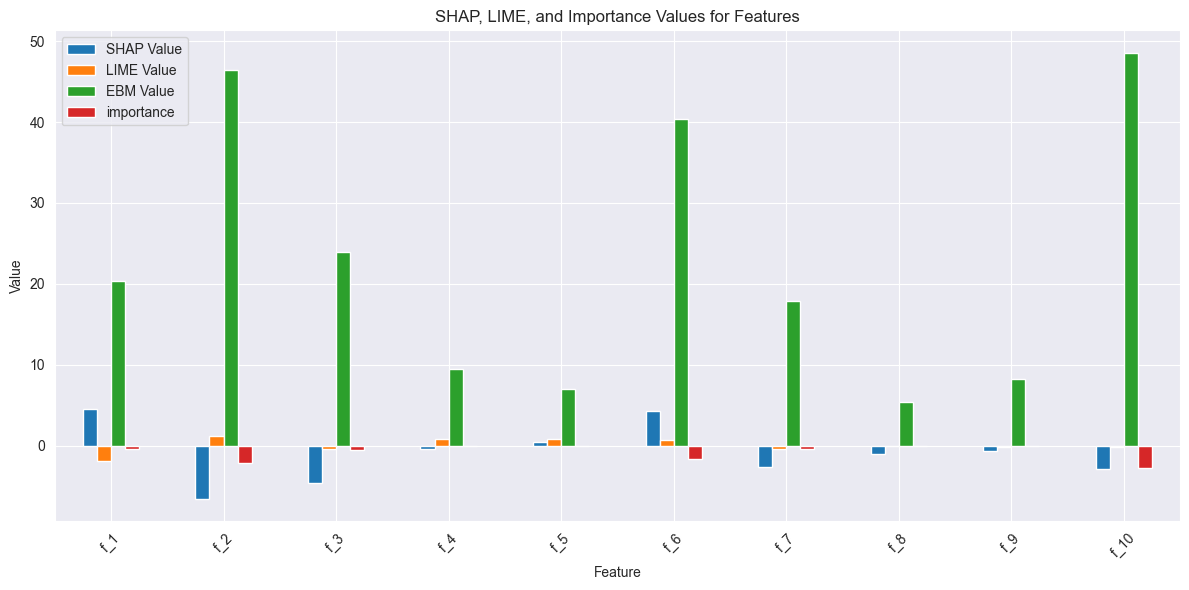


 SHAP explanation created

 LIME explanation created

 EBM explanation created

 2 features eliminated. Now the least_important_feature is  f_8
      SHAP Value  LIME Value  EBM Value    importance
f_1     4.554546   -0.639550  20.855913  -2510.937012
f_2    -6.605014   -1.243548  47.060700 -10857.474841
f_3    -4.557237   -0.123941  24.992419  -2152.400980
f_4    -0.447909   -0.472907   9.795915   -213.164681
f_6     4.311435    1.024202  39.886963  -7073.798059
f_7    -2.647601    0.468449  19.113741  -1694.976187
f_8    -1.134789   -2.125280   5.384652   -106.878854
f_9    -0.617405    0.199002   8.916709   -228.532636
f_10   -2.846813    0.236724  50.308963 -11142.374517


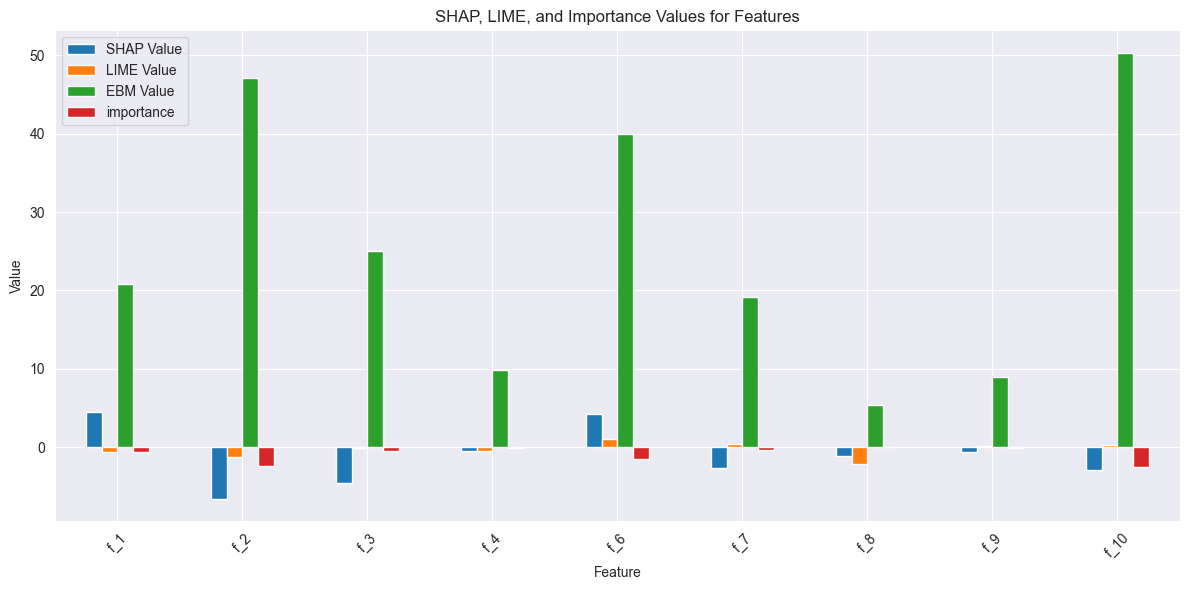


 SHAP explanation created

 LIME explanation created

 EBM explanation created

 3 features eliminated. Now the least_important_feature is  f_4
      SHAP Value  LIME Value  EBM Value    importance
f_1     4.585615    0.131603  21.684390  -2358.723155
f_2    -6.641445   -0.059948  47.683989 -10982.895083
f_3    -4.487166   -0.439325  25.005109  -2174.888485
f_4    -0.414198    0.790748   8.743311   -177.208182
f_6     4.366814    0.300979  41.561895  -8583.814234
f_7    -2.673135   -0.093963  19.526873  -1923.933082
f_9    -0.618766   -0.072757   9.838348   -260.074566
f_10   -2.851152   -1.427845  52.295085 -10841.819144


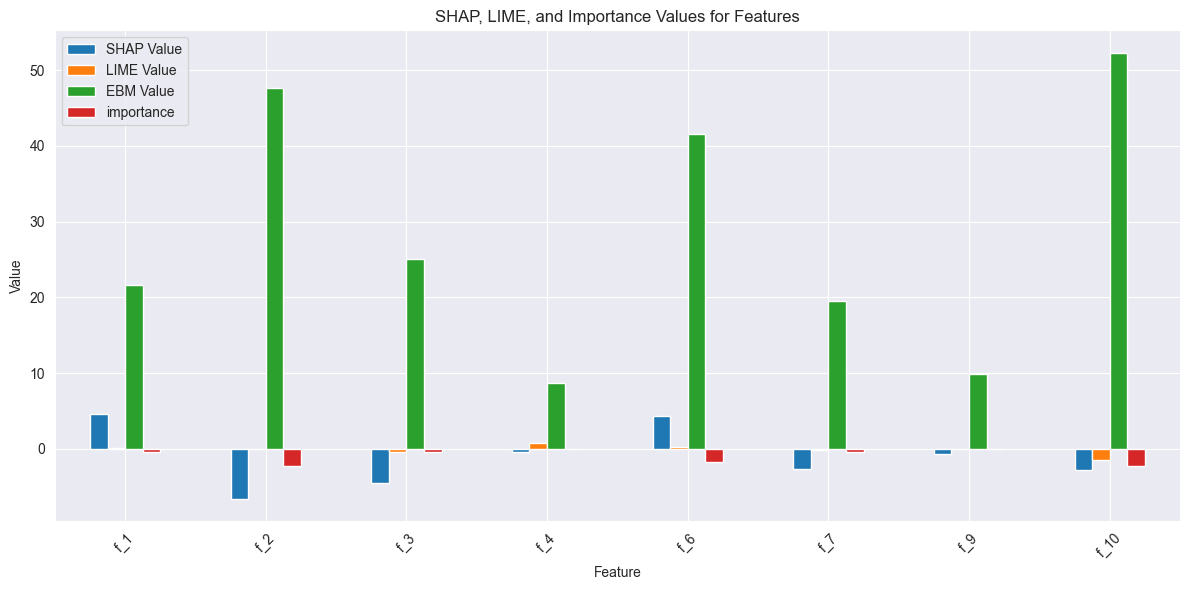


 SHAP explanation created

 LIME explanation created

 EBM explanation created

 4 features eliminated. Now the least_important_feature is  f_9
      SHAP Value  LIME Value  EBM Value    importance
f_1     4.691474    0.622112  22.926303  -2424.683463
f_2    -6.683157   -1.111932  48.551188 -11955.778663
f_3    -4.430343   -0.384173  25.151537  -2363.203464
f_6     4.352758    1.347297  42.885642  -7319.763952
f_7    -2.732003   -0.136955  21.010772  -1766.710475
f_9    -0.638220    0.085479  10.873377   -287.852360
f_10   -2.892419    1.200320  53.972169 -13068.265390


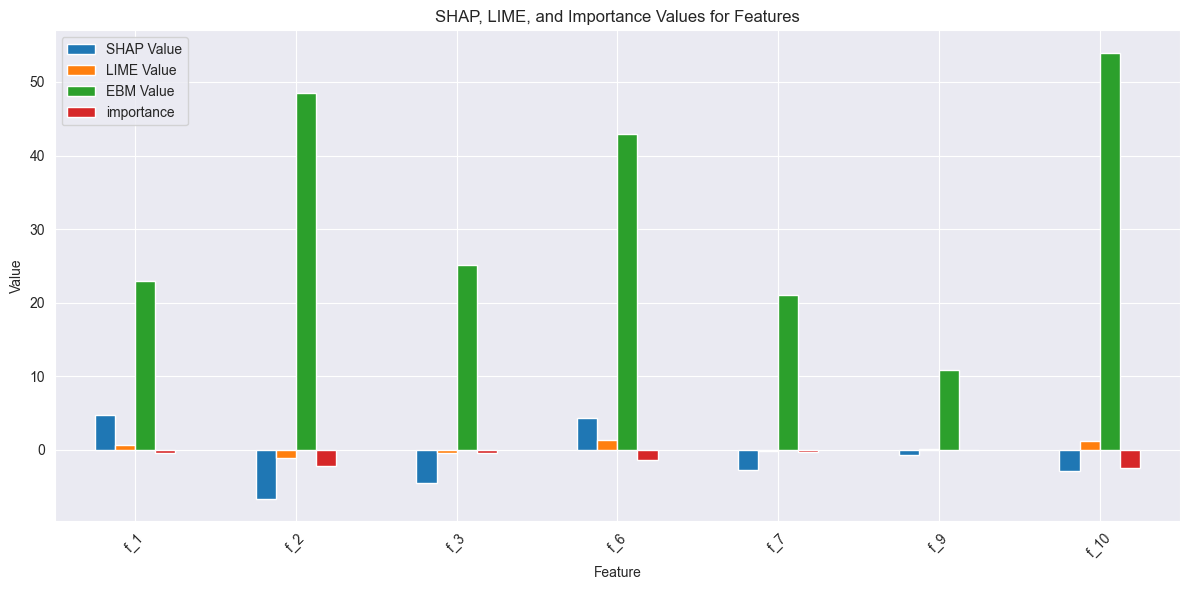


 SHAP explanation created

 LIME explanation created

 EBM explanation created

 5 features eliminated. Now the least_important_feature is  f_7
      SHAP Value  LIME Value  EBM Value    importance
f_1     4.769912   -0.593234  23.217991  -2485.842264
f_2    -6.617850    0.799358  49.581939 -10569.431309
f_3    -4.411594    0.287409  25.403428  -2313.928554
f_6     4.296555   -1.036007  43.513065  -7672.675049
f_7    -2.888803   -0.865384  21.966146  -2196.693580
f_10   -2.894356   -0.081679  55.959449 -11919.121825


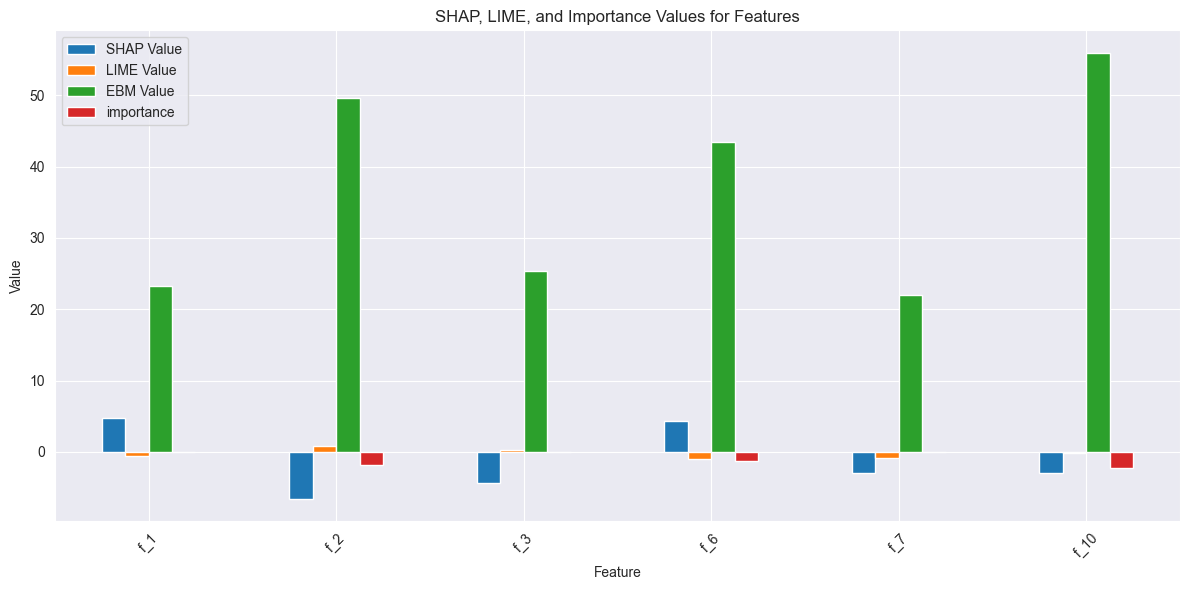


 SHAP explanation created

 LIME explanation created

 EBM explanation created

 6 features eliminated. Now the least_important_feature is  f_3
      SHAP Value  LIME Value  EBM Value    importance
f_1     4.540490   -0.057228  22.985695  -2554.152677
f_2    -6.897446    0.121575  51.995742 -11549.736142
f_3    -4.332508   -0.387215  24.755335  -2549.049018
f_6     4.302747   -0.201044  42.982987  -7414.368480
f_10   -2.701048   -0.386511  51.622014  -9558.616954


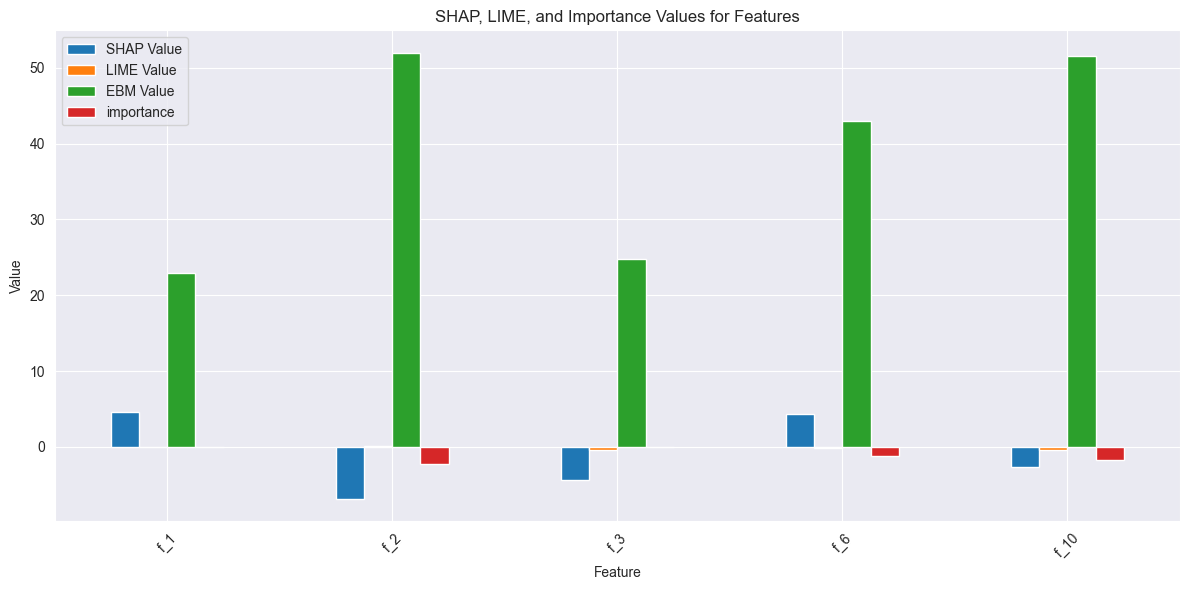


 SHAP explanation created

 LIME explanation created

 EBM explanation created

 7 features eliminated. Now the least_important_feature is  f_1
      SHAP Value  LIME Value  EBM Value    importance
f_1     4.538450    1.915112  22.469869  -2779.101217
f_2    -7.087654   -1.395869  55.181751 -12304.075828
f_6     4.283449    0.279271  42.669420  -7536.891210
f_10   -2.610469    0.636290  51.892347  -9203.515362


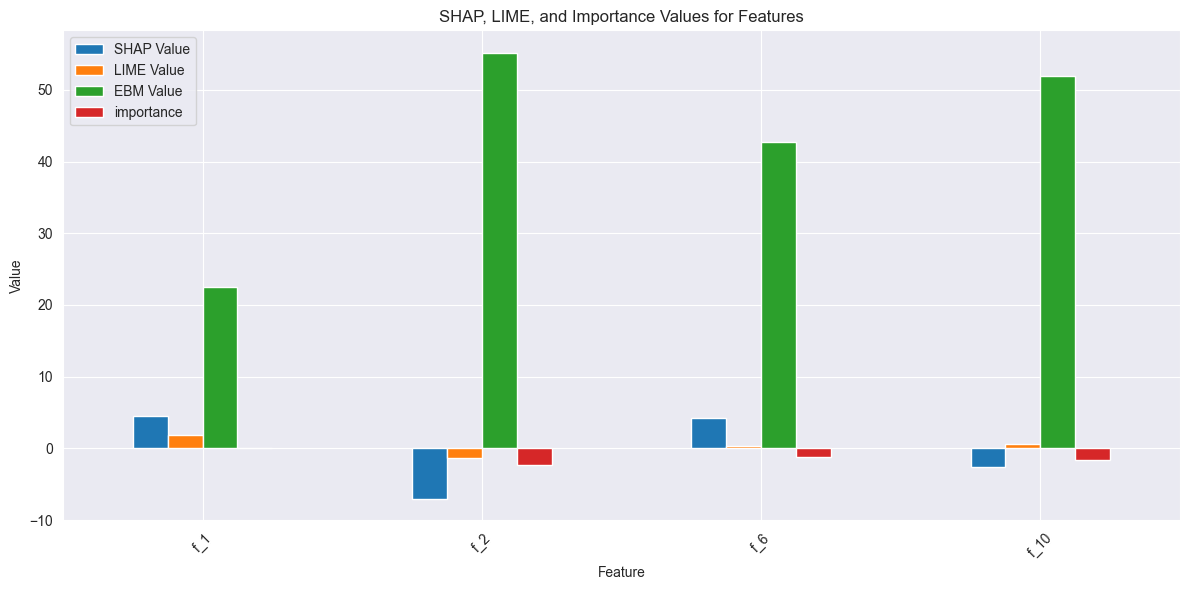

In [13]:
shap_mse_values, lime_mse_values = evaluate_explainers(model, X_test, y_test, metric='mse', threshold=0.3, random_state=42)


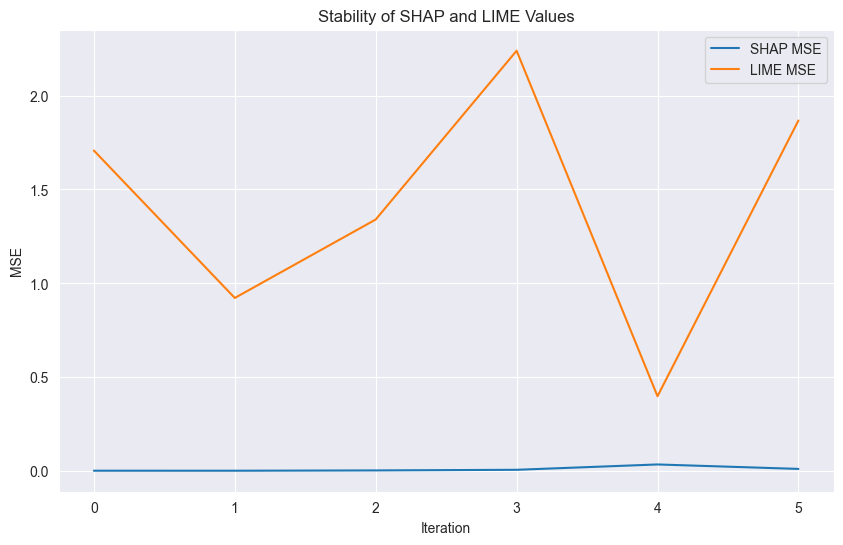

In [14]:
plot_mse(shap_mse_values, lime_mse_values)
